In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
stocks = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS']
data = {stock: yf.download(stock, start='2024-04-04', end='2024-10-04') for stock in stocks}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
def max_drawdown(prices):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(prices)
    drawdowns = (running_max - prices) / running_max
    return drawdowns.max()


In [4]:
drawdowns = {stock: max_drawdown(stock_data['Adj Close']) for stock, stock_data in data.items()}
print("Maximum Drawdowns:")
for stock, drawdown in drawdowns.items():
    print(f"{stock}: {drawdown:.2%}")

Maximum Drawdowns:
RELIANCE.NS: 11.82%
TCS.NS: 7.64%
INFY.NS: 7.22%
HDFCBANK.NS: 9.47%
HINDUNILVR.NS: 5.64%


In [5]:
selected_stock = 'RELIANCE.NS'
data_selected = data[selected_stock]

In [6]:
data_selected['50_MA'] = data_selected['Adj Close'].rolling(window=50).mean()
data_selected['200_MA'] = data_selected['Adj Close'].rolling(window=200).mean()

In [7]:
data_selected['Signal'] = 0
data_selected.iloc[50:, data_selected.columns.get_loc('Signal')] = np.where(
    data_selected['50_MA'][50:] > data_selected['200_MA'][50:], 1, -1
)

In [8]:
data_selected['Position'] = data_selected['Signal'].shift()

In [9]:
data_selected['Strategy_Return'] = data_selected['Position'] * data_selected['Adj Close'].pct_change()

In [10]:
stop_loss = 0.05  # 5%
data_selected['Stop_Loss'] = data_selected['Adj Close'].where(data_selected['Position'] == 1) * (1 - stop_loss)


In [12]:
data_selected['Adjusted_Position'] = 0  # Initialize the column
for i in range(1, len(data_selected)):
    if data_selected['Position'].iloc[i] == 1:
        # If the previous position was buy and price drops below stop loss
        if data_selected['Adj Close'].iloc[i] < data_selected['Stop_Loss'].iloc[i - 1]:
            data_selected.loc[data_selected.index[i], 'Adjusted_Position'] = 0  # Trigger stop-loss
        else:
            data_selected.loc[data_selected.index[i], 'Adjusted_Position'] = data_selected['Position'].iloc[i]
    else:
        data_selected.loc[data_selected.index[i], 'Adjusted_Position'] = data_selected['Position'].iloc[i]

In [13]:
data_selected['Strategy_Return_With_SL'] = data_selected['Adjusted_Position'] * data_selected['Adj Close'].pct_change()

In [14]:
data_selected['Cumulative_Strategy_Return'] = (1 + data_selected['Strategy_Return']).cumprod() - 1
data_selected['Cumulative_Strategy_Return_With_SL'] = (1 + data_selected['Strategy_Return_With_SL']).cumprod() - 1


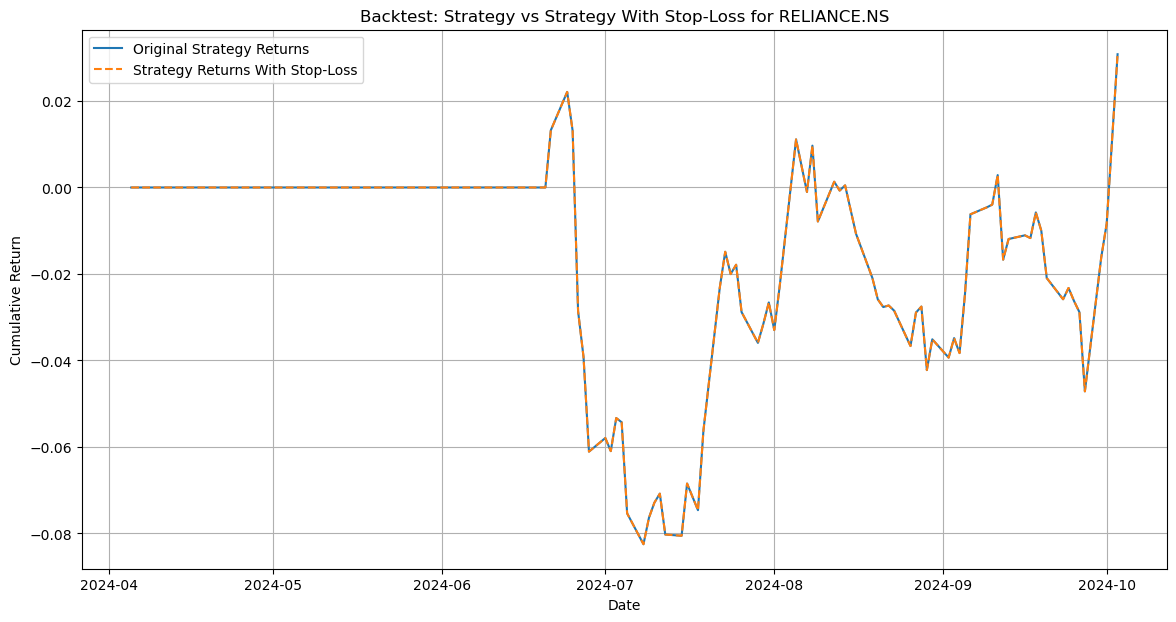

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(data_selected['Cumulative_Strategy_Return'], label='Original Strategy Returns')
plt.plot(data_selected['Cumulative_Strategy_Return_With_SL'], label='Strategy Returns With Stop-Loss', linestyle='--')
plt.title(f'Backtest: Strategy vs Strategy With Stop-Loss for {selected_stock}')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [16]:
final_strategy_return = data_selected['Cumulative_Strategy_Return'].iloc[-1]
final_strategy_return_with_sl = data_selected['Cumulative_Strategy_Return_With_SL'].iloc[-1]
print("Final Original Strategy Return: ", final_strategy_return)
print("Final Strategy Return With Stop-Loss: ", final_strategy_return_with_sl)

Final Original Strategy Return:  0.03081633390803118
Final Strategy Return With Stop-Loss:  0.03081633390803118
